# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


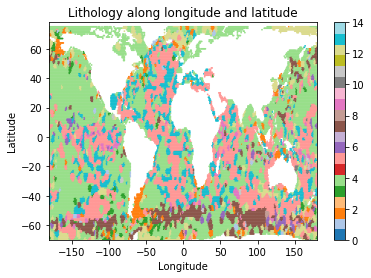

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

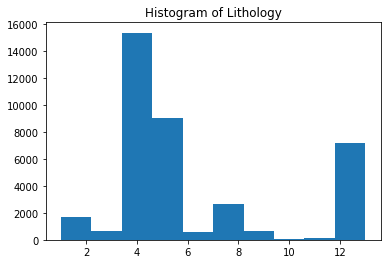

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

In [4]:
training_data = dfdata.copy()

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Output layer

In [5]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

Using TensorFlow backend.


In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(numclass, activation="softmax", kernel_initializer=initializer))
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

In [7]:
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)

train_indice, test_indice = [], []
for train, test in kfold.split(X):
    train_indice.append(train)
    test_indice.append(test)
    
result = np.zeros((len(Y), len(np.unique(Y))))

for train_ind, test_ind in kfold.split(X):
    Xtrain = X[train_ind]
    Ytrain = dummy_Y[train_ind]
    Xtest = X[test_ind]
    # train
    estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=True)
    estimator.fit(X[train_ind], dummy_Y[train_ind], class_weight=weight)
    # predict
    prediction = estimator.predict_proba(X[test_ind])
    result[test_ind, :] = prediction

Epoch 1/200
25366/25366 [==============================] - 4s 157us/step - loss: 1.5072 - accuracy: 0.4787
Epoch 2/200
25366/25366 [==============================] - 4s 153us/step - loss: 1.4044 - accuracy: 0.5195
Epoch 3/200
25366/25366 [==============================] - 4s 154us/step - loss: 1.3695 - accuracy: 0.5316
Epoch 4/200
25366/25366 [==============================] - 4s 153us/step - loss: 1.3497 - accuracy: 0.5385
Epoch 5/200
25366/25366 [==============================] - 4s 155us/step - loss: 1.3366 - accuracy: 0.5436
Epoch 6/200
25366/25366 [==============================] - 4s 155us/step - loss: 1.3224 - accuracy: 0.5442
Epoch 7/200
25366/25366 [==============================] - 4s 154us/step - loss: 1.3083 - accuracy: 0.5490
Epoch 8/200
25366/25366 [==============================] - 4s 154us/step - loss: 1.2950 - accuracy: 0.5492
Epoch 9/200
25366/25366 [==============================] - 4s 154us/step - loss: 1.2818 - accuracy: 0.5543
Epoch 10/200
25366/25366 [===========

In [8]:
result_discrete = result.argmax(axis=1)
result_discrete

array([ 3,  3,  3, ..., 11,  3,  6])

In [9]:
result

array([[6.50068687e-04, 1.46611434e-04, 3.40744606e-08, ...,
        1.67194094e-06, 3.19959298e-02, 1.19793953e-07],
       [1.11113152e-09, 2.01371549e-05, 4.45349920e-13, ...,
        1.42092349e-12, 8.58392508e-04, 6.67136513e-10],
       [1.14072363e-10, 2.71935164e-06, 2.35030687e-14, ...,
        3.01778459e-14, 1.72443688e-04, 2.87716795e-11],
       ...,
       [2.02831882e-03, 6.62122434e-03, 1.95974787e-03, ...,
        1.07011147e-05, 9.31894660e-01, 1.60722222e-04],
       [1.42305886e-04, 8.48072302e-03, 1.49663463e-02, ...,
        1.75189867e-04, 4.03991401e-01, 1.02814083e-05],
       [2.15479419e-01, 8.78375694e-02, 1.52840260e-02, ...,
        3.40890954e-03, 1.75979227e-01, 2.49696244e-03]])

Accuracy = 0.6361008173670792


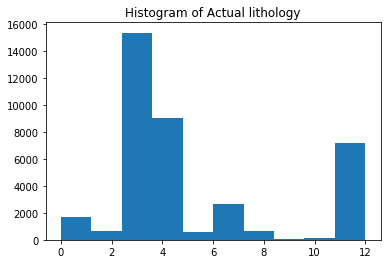

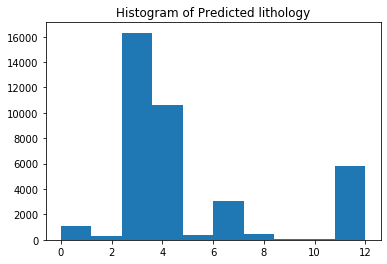

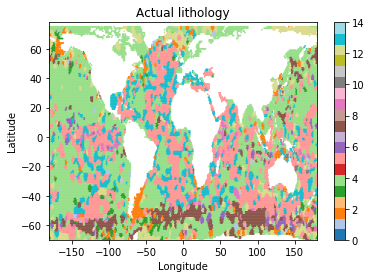

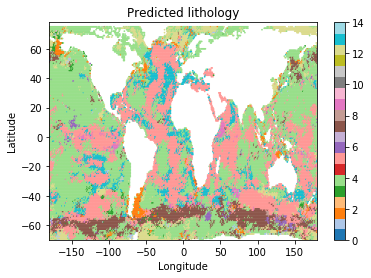

In [10]:
print("Accuracy = {}".format(accuracy_score(Y, result_discrete)))
draw_hist(Y, "Histogram of Actual lithology")
draw_hist(result_discrete, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, result_discrete + 1, "Predicted lithology")

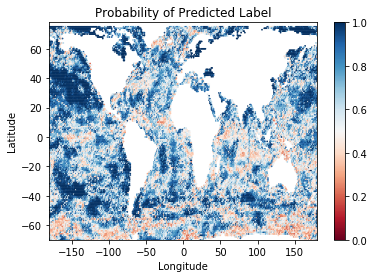

In [16]:
prob = np.max(result, axis=1)
draw_global(lon, lat, prob, "Probability of Predicted Label", cmap='RdBu', vmin=0, vmax=1)